In [57]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from ast import literal_eval
from itertools import zip_longest
import numpy as np
# from tabulate import tabulate

# For latex graphs
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

def plot_all_both(method):
    fig, axs = plt.subplots(2)
    fig.set_size_inches(w=5.39749, h=6)
    names = ["cellulitis", "copper", "search", "uti", "overdiagnosis", "bacteriuria", "telehealth"]
    for name in names:
        effort_accuracy_plot(name, method, True, axs[0])
        effort_accuracy_plot(name, method, False, axs[1])
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0.2, 1.1, 0.1))
    plt.legend()
    # plt.show()

def plot_all(method, show_all=True):
    fig = plt.figure()
    fig.set_size_inches(w=5.39749, h=3)
    names = ["cellulitis", "copper", "search", "uti", "overdiagnosis", "bacteriuria", "telehealth"]
    sns.set(style="whitegrid")
    for name in names:
        effort_accuracy_plot(name, method, show_all)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0.2, 1.1, 0.1))
    plt.legend()
    # plt.show()
    
# Get the accuracy at a threshold effort
def get_accuracy(name, method, effort):
    stats_df = pd.read_csv("stats/stats-" + name + "-" + method + ".csv")
    # Convert csv lists to actual lists
    stats_df.effort = stats_df.effort.apply(literal_eval)
    stats_df.accuracy = stats_df.accuracy.apply(literal_eval)

    # Find longest effort array
    avg_effort = max(stats_df.effort, key=len)
    # Average all accuracy data points over the 10 iterations
    avg_accuracy = np.nanmean(np.array(list(zip_longest(*stats_df.accuracy, fillvalue=1)),dtype=float), axis=1)
    
    # Find lowest index where accuracy exceeds or equals the accuracy
    index = np.argmax(avg_effort>=effort)
    return avg_accuracy[index]

def get_effort(name, method, accuracy):
    stats_df = pd.read_csv("stats/stats-" + name + "-" + method + ".csv")
    # Convert csv lists to actual lists
    stats_df.effort = stats_df.effort.apply(literal_eval)
    stats_df.accuracy = stats_df.accuracy.apply(literal_eval)

    # Find longest effort array
    effort = max(stats_df.effort, key=len)
    # Average all accuracy data points over the 10 iterations
    avg_accuracy = np.nanmean(np.array(list(zip_longest(*stats_df.accuracy, fillvalue=1)),dtype=float), axis=1)
    
    # Find lowest index where accuracy exceeds or equals the accuracy
    index = np.argmax(avg_accuracy>=accuracy)
    return effort[index]
    
def print_table(method):
    table = []
    accuracies = [0.5, 0.75, 0.9, 1.0]
    names = ["cellulitis", "copper", "search", "uti", "overdiagnosis"]
    for name in names:
        row = [name]
        for accuracy in accuracies:
            row.append(get_effort(name, method, accuracy))
        table.append(row)
    print(tabulate(table, tablefmt='latex', floatfmt=".2f"))
    
def plot_table():
    table = []
    accuracies = [0.5, 0.75, 0.9, 1.0]
    names = ["cellulitis", "copper", "search", "uti", "overdiagnosis"]
    for name in names:
        for accuracy in accuracies:
            table.append([name, accuracy, get_effort(name, accuracy)])
    df = pd.DataFrame(table, columns=["name", "accuracy", "effort"])
    sns.set(style="whitegrid", rc={'figure.figsize':(5.39749, 3)})
    sns.barplot(x="accuracy", y="effort", hue="name", data=df)
    plt.xlabel("accuracy threshold")

def effort_accuracy_plot(name, method, show_all=True, plot=plt):
    stats_df = pd.read_csv("stats/stats-" + name + "-" + method + ".csv")
    # Convert csv lists to actual lists
    stats_df.effort = stats_df.effort.apply(literal_eval)
    stats_df.accuracy = stats_df.accuracy.apply(literal_eval)

    # Find longest effort array
    effort = max(stats_df.effort, key=len)
    # Average all accuracy data points over the 10 iterations
    avg_accuracy = np.nanmean(np.array(list(zip_longest(*stats_df.accuracy, fillvalue=1)),dtype=float), axis=1).tolist()

    # Add values to show all
    if (show_all):
        effort.append(1)
        avg_accuracy.append(max(avg_accuracy))


    # Make plot look nice
    plt.xlabel("effort")
    plt.ylabel("accuracy")
    plot.plot(effort, avg_accuracy, label=name, linewidth=2)

[0 1 2]
[0.19737948017808846, 0.23072304359661766, 0.29331666455804634]
[0.18046525143373632, 0.21662553373449578, 0.2986812811113205]
[0.2060052407461081, 0.24376812766732586, 0.37681794893416537]
[0.19918195934641109, 0.23890422573159215, 0.295879795518622]
[0.18266048400565202, 0.21622720317740868, 0.25429716707093314]
[0.20073231836476726, 0.23910644344280052, 0.33998585756761585]
[0.25069767584471325, 0.27374479521307443, 0.3171629142772229]
[0.26723873647406177, 0.30634834517225773, 0.37247769130697383]
[0.2199174165421252, 0.25329394970842084, 0.32252035661958367]


/var/folders/8q/byh6pjkx74d7p_crfrzgdpbd2xgt0t/T/ipykernel_7535/1177961034.py:62: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


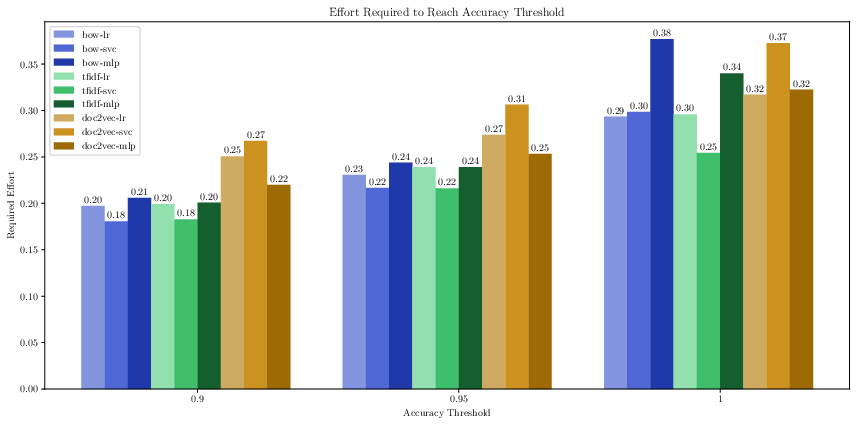

In [99]:
# Plot bar plot of average model performance
colormap = [
	# Blues
	"#8495e0",
	"#4f68d6",
	"#1f39ab",
	# Greens
	"#92e0ad",
	"#3fbf6b",
	"#155e2e",
	# Oranges
	"#cfaa61",
	"#cc921f",
	"#9e6a03",
]

datasets = ["bacteriuria", "cellulitis", "copper", "overdiagnosis", "search", "telehealth", "uti"]
embeddings=["bow", "tfidf", "doc2vec"]
classifiers=["lr", "svc", "mlp"]
model_names = []
for embedding in embeddings:
	for classifier in classifiers:
		model_names.append(embedding + "-" + classifier)

def get_average_effort_at_accuracy(model_name, accuracy):
	efforts = []
	for dataset in datasets:
		efforts.append(get_effort(dataset, model_name, accuracy))
	# Return average
	return sum(efforts) / len(efforts)

accuracy_thresholds = [0.9, 0.95, 1]
x = np.arange(len(accuracy_thresholds))  # the label locations
print(x)
width = 0.8 # the width of the bars
fig, ax = plt.subplots()
fig.set_size_inches(w=12, h=6)
rects = []

length = len(model_names)
for i, model_name in enumerate(model_names):
	required_efforts = []
	for accuracy in accuracy_thresholds:
		required_efforts.append(get_average_effort_at_accuracy(model_name, accuracy))
	print(required_efforts)
	color=colormap[i%9]
	i = i - len(model_names)/2 # Offset bar to left
	rects.append(ax.bar(x + i * (width/length), required_efforts, width/length, label=model_name, color=color))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Accuracy Threshold')
ax.set_ylabel('Required Effort')
ax.set_title('Effort Required to Reach Accuracy Threshold')
ax.set_xticks(x, accuracy_thresholds)
ax.legend()

for rect in rects:
	ax.bar_label(rect, padding=3, fmt='%.2f')

fig.tight_layout()

plt.show()


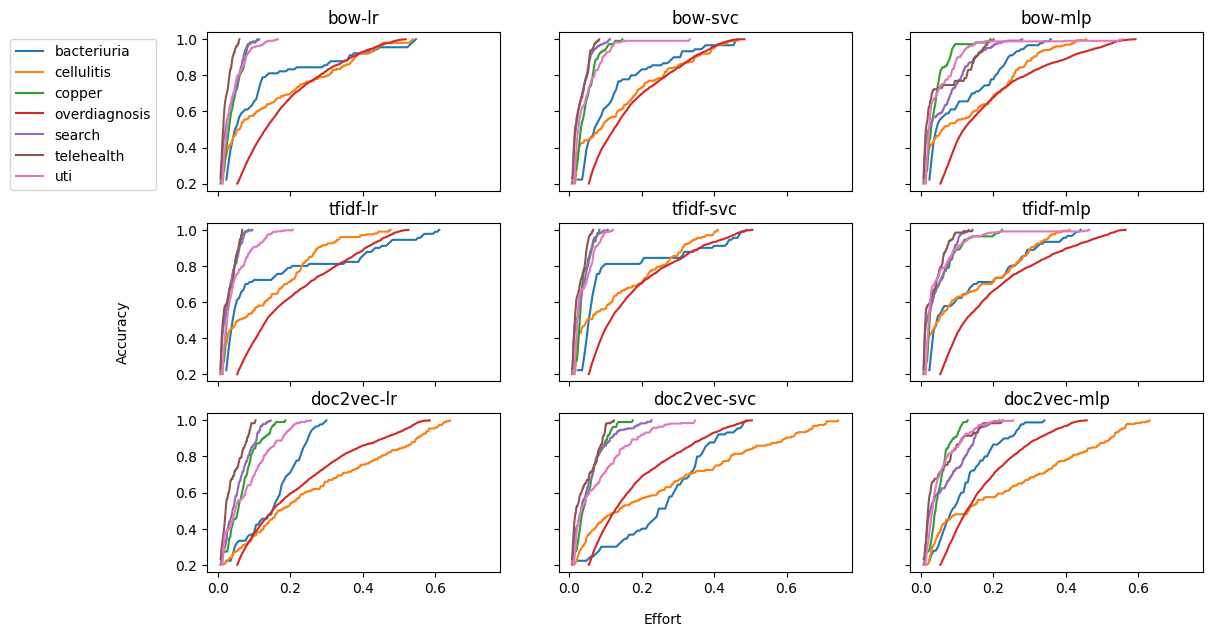

<Figure size 1500x1000 with 0 Axes>

In [3]:
# Plot all models on one plot
import matplotlib.pyplot as plt
import pandas as pd
from ast import literal_eval
import numpy as np
from itertools import zip_longest

# Create nine polar axes and access them through the returned array
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)
# fig.set_size_inches(w=5.39749, h=3)
fig.set_size_inches(w=12, h=6)
# Set common labels
fig.text(0.55, 0.02, 'Effort', ha='center', va='center')
fig.text(0.1, 0.5, 'Accuracy', ha='center', va='center', rotation='vertical')

embeddings=["bow", "tfidf", "doc2vec"]
classifiers=["lr", "svc", "mlp"]
datasets = ["bacteriuria", "cellulitis", "copper", "overdiagnosis", "search", "telehealth", "uti"]

for i, embedding in enumerate(embeddings):
	for j, classifier in enumerate(classifiers):
		for dataset in datasets:
			model = embedding + "-" + classifier
			stats_df = pd.read_csv("stats/stats-" + dataset + "-" + model + ".csv")
			# Convert csv lists to actual lists
			stats_df.effort = stats_df.effort.apply(literal_eval)
			stats_df.accuracy = stats_df.accuracy.apply(literal_eval)
			# Find longest effort array
			effort = max(stats_df.effort, key=len)
			# Average all accuracy data points over the 10 iterations
			avg_accuracy = np.nanmean(np.array(list(zip_longest(*stats_df.accuracy, fillvalue=1)),dtype=float), axis=1).tolist()
			axs[i,j].plot(effort, avg_accuracy, label=dataset, linewidth=1.5)
			axs[i,j].set_title(model)

handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0,1),loc='upper left')
plt.subplots_adjust(left=0.17, bottom=0.1, top=1, right=1)

plt.figure(figsize=(15,10))
plt.show()

In [8]:
method = "control"

plot_all(method, False)
plt.tight_layout()
plt.savefig('../honours/thesis/Figures/effort-accuracy-' + method + '.pgf')